In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU,SimpleRNN
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
import random
import os
def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(1234)
    tf.random.set_seed(1234)
    np.random.seed(1234)
    random.seed(1234)

In [3]:
#read csv, print 5 rows
klangapi = pd.read_csv('klangapiCleanedDailyMean.csv')
klangapi=klangapi.replace(0.0000,np.NaN)
#klangapi[(klangapi == 0.0).any(axis=1)]
klangapi.interpolate(method ='linear', limit_direction ='forward', inplace=True)

#change data type "date" from object to actual date for easy analysis
klangapi['date']=pd.to_datetime(klangapi['date'])
#set index to date
klangapi.set_index('date',inplace=True)
klangapi.drop(['nox'], axis=1, inplace=True)

klangapi.head(10)

,wind_speed,wind_direction,temperature,relative_humidity,no,so2,no2,o3,co,pm10
date,,,,,,,,,,
2002-10-01,4.2125,170.1875,27.3729,72.7500,0.0409,0.0097,0.0342,0.0241,2.3044,108.6875
2002-10-02,4.9542,111.8750,27.4375,72.8333,0.0247,0.0077,0.0354,0.0203,1.7673,108.3333
2002-10-03,5.0542,123.2083,26.8250,77.0833,0.0261,0.0119,0.0349,0.0191,1.7481,99.9583
2002-10-04,3.6958,134.3750,26.4875,79.2500,0.0506,0.0121,0.0366,0.0191,2.4892,116.6250
2002-10-05,4.4708,188.9167,26.4750,80.3333,0.0305,0.0072,0.0234,0.0165,1.7731,94.9583
2002-10-06,4.3167,142.6667,26.0750,82.4167,0.0229,0.0074,0.0242,0.0202,1.5633,83.7083
2002-10-07,3.9583,177.5000,25.4000,84.0625,0.0487,0.0089,0.0250,0.0120,1.9575,75.5625
2002-10-08,5.4917,137.3750,27.5083,76.7500,0.0105,0.0071,0.0154,0.0188,0.9352,53.6458
2002-10-09,5.1500,164.2083,27.8250,74.8333,0.0149,0.0090,0.0177,0.0311,1.0512,70.3958


In [4]:
trainTest=klangapi.loc['2002-01-01':'2019-12-31'].copy() #2002-2017/3/31
verifyDeploy=klangapi.loc['2020-01-01':'2020-12-31'].copy() #2018
jumlahTrainNTest=trainTest.shape[0]
jumlahVerification=verifyDeploy.shape[0]
print(jumlahTrainNTest,jumlahVerification,jumlahTrainNTest+jumlahVerification)

6039 366 6405


In [5]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# scaler = StandardScaler()
# scaler = scaler.fit(klangapi)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(klangapi)
trainTestScaled = scaler.transform(trainTest)
verifyDeployScaled = scaler.transform(verifyDeploy)
trainTestScaled.shape,verifyDeployScaled.shape

((6039, 10), (366, 10))

In [6]:
##splitting dataset into train and test split
training_size=int(len(trainTestScaled)*0.85)
test_size=len(trainTestScaled)-training_size
train,test=trainTestScaled[0:training_size,:],trainTestScaled[training_size:len(trainTestScaled),:]
train.shape,test.shape

((5133, 10), (906, 10))

## END OF SEGMENT

In [7]:
# references target features
# 10 = pm10
# 9 = co
# 8 = o3
# 7 = no2
# 6 = so2
# 5 = no
# 4 = nox

In [8]:
# function to organize data in correct forms so that the data can be fitted to the model
# data, number of past days, number of features, target pollutants to be predicted
def to_sequences(dataset, n_past, no_features, target_features):
    # n_past: Number of past days we want to use to predict the future.
    X = []
    y = []
    n_future = 1   # Number of days we want to look into the future based on the past days.
    for i in range(n_past, len(dataset) - n_future +1):
        X.append(dataset[i - n_past:i, 0:no_features])
        y.append(dataset[i + n_future - 1:i + n_future, target_features]) 
    return np.array(X), np.array(y)



# function to build LSTM model
def modelling(train, test, past_days, target_features):
    reset_random_seeds()
    
    #structuring the shape of training data into (number of rows, number of past days, number of features)
    #structuring the shape of target features into (number of rows, number of feature)
    trainX, trainY = to_sequences(train, past_days, klangapi.shape[1],target_features)
    testX, testY = to_sequences(test, past_days, klangapi.shape[1],target_features)
    verifyX, verifyY = to_sequences(verifyDeployScaled, past_days, klangapi.shape[1],target_features)

    print('trainX shape == {}.'.format(trainX.shape))
    print('trainY shape == {}.'.format(trainY.shape))
    print('testX shape == {}.'.format(testX.shape))
    print('testY shape == {}.'.format(testY.shape))
    print('verifyX shape == {}.'.format(verifyX.shape))
    print('verifyY shape == {}.'.format(verifyY.shape))
    print('\n')
    
    #modelling
    model = Sequential()
    model.add(GRU(32, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
#     model.add(LSTM(448, activation='tanh', return_sequences=False))
#     model.add(Dense(64))
    # model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(trainY.shape[1]))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.summary()
    history = model.fit(trainX, trainY, epochs=20, batch_size=8, validation_split=0.2, verbose=1)
    
    print('Loss wrt epoch : ')
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.show() 
    
    prediction = model.predict(testX)
    prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
    y_pred_future = scaler.inverse_transform(prediction_copies)[:,target_features]
    actualY = np.repeat(testY, klangapi.shape[1], axis=-1)
    actualY = scaler.inverse_transform(actualY)[:,target_features]
    print('\n')
    
    print('Model performance on training data : ')
    rmse, mae, mape = performance_measure(actualY,y_pred_future)
    print('RMSE : {}.'.format(rmse))
    print('MAE : {}.'.format(mae))
    print('MAPE : {}.'.format(mape))
    print('How model predict training data : ')
    train_results = pd.DataFrame(data={'Train Predictions':y_pred_future, 'Actuals':actualY})     
    plt.plot(train_results['Actuals'][0:])
    plt.plot(train_results['Train Predictions'][0:])
    plt.show()

    prediction = model.predict(verifyX)
    prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
    y_pred_future_test = scaler.inverse_transform(prediction_copies)[:,target_features]
    verificationYRepeat = np.repeat(verifyY, klangapi.shape[1], axis=-1)
    verificationYUnscaled = scaler.inverse_transform(verificationYRepeat)[:,target_features]
    print('Model performance on verification data : ')
    rmse, mae, mape = performance_measure(verificationYUnscaled,y_pred_future_test)
    print('RMSE : {}.'.format(rmse))
    print('MAE : {}.'.format(mae))
    print('MAPE : {}.'.format(mape))
    test_results = pd.DataFrame(data = {'Train Predictions':y_pred_future_test, 'Actuals':verificationYUnscaled})
    print('How model predict verification data : ')
    plt.plot(test_results['Actuals'][:])
    plt.plot(test_results['Train Predictions'][:])
    plt.show()
    
    # function to retrieve performance of the model
def performance_measure(actual,pred) :
    rmse=math.sqrt(mean_squared_error(actual,pred, squared=False))
    mae=mean_absolute_error(actual, pred)
    mape=mean_absolute_percentage_error(actual, pred)*100
    return rmse,mae,mape


Modelling for : no.
trainX shape == (5130, 3, 10).
trainY shape == (5130, 1).
testX shape == (903, 3, 10).
testY shape == (903, 1).
verifyX shape == (363, 3, 10).
verifyY shape == (363, 1).


Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_43 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_85 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0177 - val_loss: 0.0051
Epoch 2/20
513/513 [==============================] - 0s 802us/step - loss: 0.0123 - val_

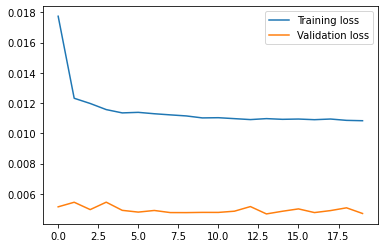



Model performance on training data : 
RMSE : 0.09181258808277266.
MAE : 0.007322202192889662.
MAPE : 154.26187211515503.
How model predict training data : 


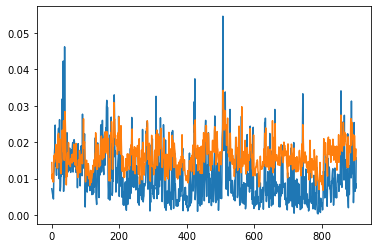

Model performance on verification data : 
RMSE : 0.09488306557802349.
MAE : 0.008318857689932522.
MAPE : 184.60344949889492.
How model predict verification data : 


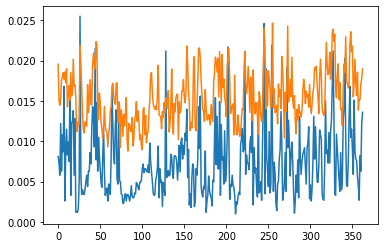





Modelling for : so2.
trainX shape == (5130, 3, 10).
trainY shape == (5130, 1).
testX shape == (903, 3, 10).
testY shape == (903, 1).
verifyX shape == (363, 3, 10).
verifyY shape == (363, 1).


Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_44 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_86 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0111 - val_loss: 0.0033
Epoch 2/20
513/513 [==============================] - 0s 804us/step - loss: 0.0068 -

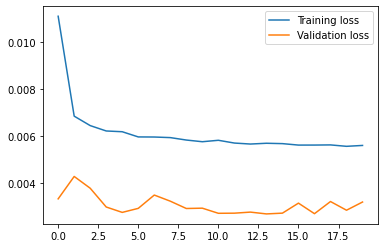



Model performance on training data : 
RMSE : 0.0452821788364274.
MAE : 0.0019051049143059442.
MAPE : 156.62186310801243.
How model predict training data : 


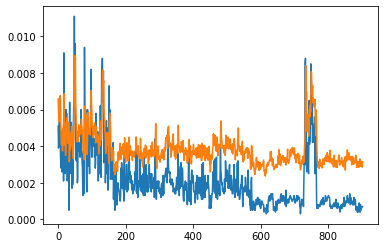

Model performance on verification data : 
RMSE : 0.04774704258551821.
MAE : 0.0022189779858379404.
MAPE : 214.8940382905733.
How model predict verification data : 


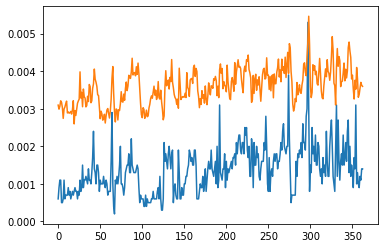





Modelling for : no2.
trainX shape == (5130, 3, 10).
trainY shape == (5130, 1).
testX shape == (903, 3, 10).
testY shape == (903, 1).
verifyX shape == (363, 3, 10).
verifyY shape == (363, 1).


Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_45 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_87 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0236 - val_loss: 0.0116
Epoch 2/20
513/513 [==============================] - 0s 806us/step - loss: 0.0162 -

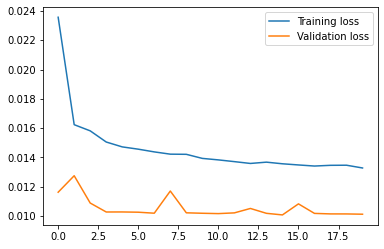



Model performance on training data : 
RMSE : 0.06832910969872466.
MAE : 0.003839164660095442.
MAPE : 26.760094964854776.
How model predict training data : 


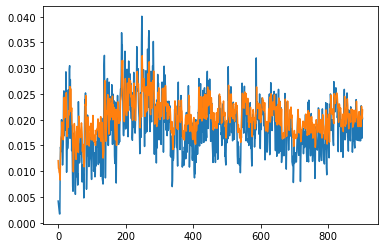

Model performance on verification data : 
RMSE : 0.07165367462328008.
MAE : 0.004314296572361932.
MAPE : 38.77443152154446.
How model predict verification data : 


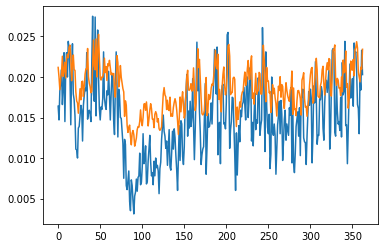





Modelling for : o3.
trainX shape == (5130, 3, 10).
trainY shape == (5130, 1).
testX shape == (903, 3, 10).
testY shape == (903, 1).
verifyX shape == (363, 3, 10).
verifyY shape == (363, 1).


Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_46 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_88 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_88 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0150 - val_loss: 0.0117
Epoch 2/20
513/513 [==============================] - 0s 822us/step - loss: 0.0118 - 

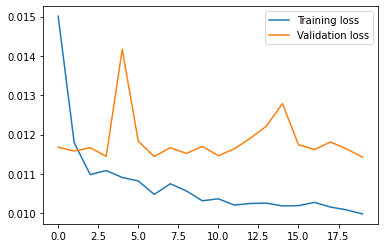



Model performance on training data : 
RMSE : 0.06886675150309059.
MAE : 0.003765119873505428.
MAPE : 34.146790959704056.
How model predict training data : 


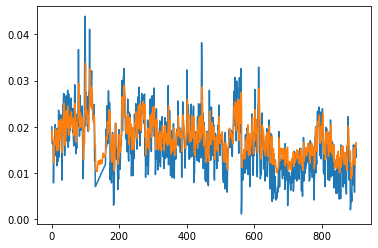

Model performance on verification data : 
RMSE : 0.06543145174683242.
MAE : 0.003343222704020742.
MAPE : 26.843109397464243.
How model predict verification data : 


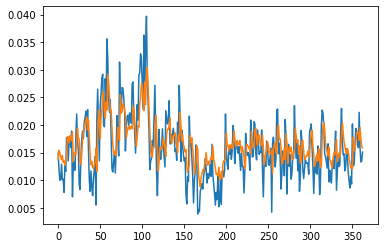





Modelling for : co.
trainX shape == (5130, 3, 10).
trainY shape == (5130, 1).
testX shape == (903, 3, 10).
testY shape == (903, 1).
verifyX shape == (363, 3, 10).
verifyY shape == (363, 1).


Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_47 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_89 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0077 - val_loss: 0.0030
Epoch 2/20
513/513 [==============================] - 0s 809us/step - loss: 0.0042 - 

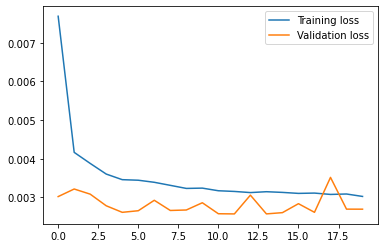



Model performance on training data : 
RMSE : 0.4507539504428018.
MAE : 0.16370300411776714.
MAPE : 24.1369287737236.
How model predict training data : 


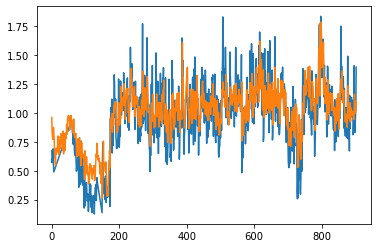

Model performance on verification data : 
RMSE : 0.42449195682252294.
MAE : 0.14645656279781963.
MAPE : 21.37707113149874.
How model predict verification data : 


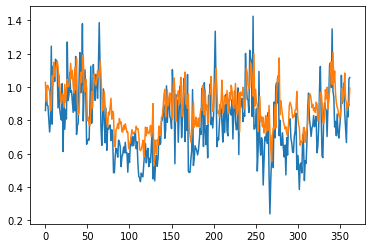





Modelling for : pm10.
trainX shape == (5130, 3, 10).
trainY shape == (5130, 1).
testX shape == (903, 3, 10).
testY shape == (903, 1).
verifyX shape == (363, 3, 10).
verifyY shape == (363, 1).


Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_48 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_90 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0052 - val_loss: 0.0030
Epoch 2/20
513/513 [==============================] - 0s 733us/step - loss: 0.0021 

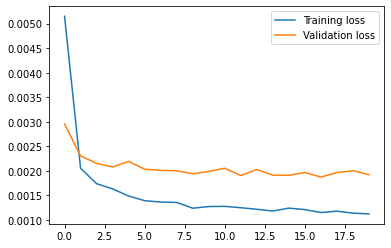



Model performance on training data : 
RMSE : 4.10221640984498.
MAE : 12.833383497705807.
MAPE : 36.55493891019212.
How model predict training data : 


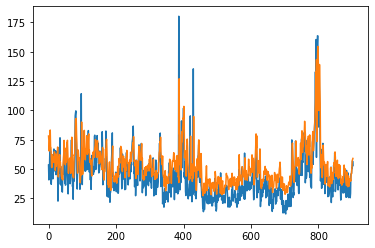

Model performance on verification data : 
RMSE : 3.681794708286145.
MAE : 11.467543330942368.
MAPE : 39.997225419186606.
How model predict verification data : 


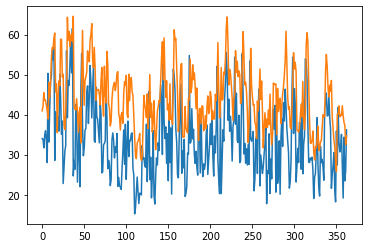

In [69]:
for i in range(4,len(klangapi.columns)):
    print('Modelling for : {}.'.format(klangapi.columns[i]))
    modelling(train,test, 3, i)
    print('\n')
    print('\n')

modelling(train,test,3,5)

Modelling for : no.
trainX shape == (5131, 2, 10).
trainY shape == (5131, 1).
testX shape == (904, 2, 10).
testY shape == (904, 1).
verifyX shape == (364, 2, 10).
verifyY shape == (364, 1).


Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_54 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0070
Epoch 2/20
513/513 [==============================] - 0s 637us/step - loss: 0.0122 - val_

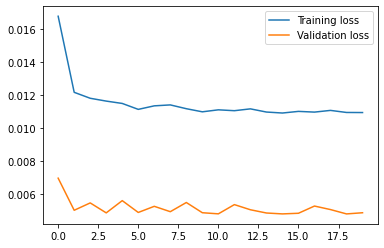



Model performance on training data : 
RMSE : 0.09072198298202389.
MAE : 0.0070684977852269616.
MAPE : 146.6226182621301.
How model predict training data : 


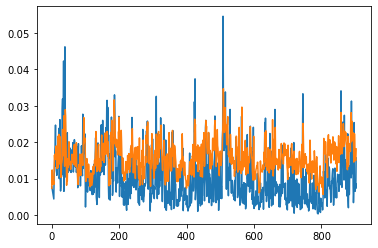

Model performance on verification data : 
RMSE : 0.09447104805082725.
MAE : 0.008181372280901933.
MAPE : 179.66684994910867.
How model predict verification data : 


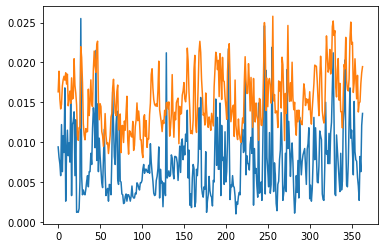





Modelling for : so2.
trainX shape == (5131, 2, 10).
trainY shape == (5131, 1).
testX shape == (904, 2, 10).
testY shape == (904, 1).
verifyX shape == (364, 2, 10).
verifyY shape == (364, 1).


Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_13 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_55 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0101 - val_loss: 0.0033
Epoch 2/20
513/513 [==============================] - 0s 651us/step - loss: 0.0068 -

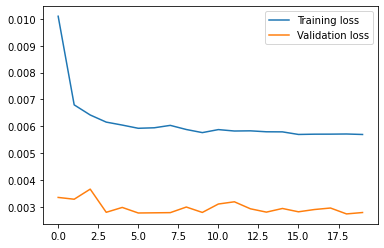



Model performance on training data : 
RMSE : 0.04246028130918337.
MAE : 0.0016522182702737968.
MAPE : 135.69909212078585.
How model predict training data : 


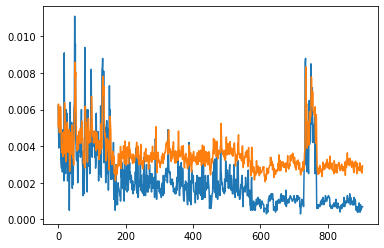

Model performance on verification data : 
RMSE : 0.044324844471073724.
MAE : 0.001898282969281446.
MAPE : 185.6972190018351.
How model predict verification data : 


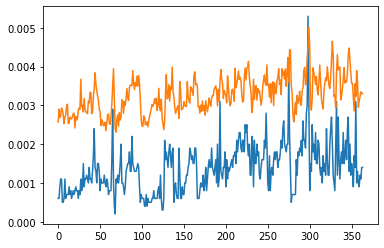





Modelling for : no2.
trainX shape == (5131, 2, 10).
trainY shape == (5131, 1).
testX shape == (904, 2, 10).
testY shape == (904, 1).
verifyX shape == (364, 2, 10).
verifyY shape == (364, 1).


Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_14 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_56 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0231 - val_loss: 0.0134
Epoch 2/20
513/513 [==============================] - 0s 646us/step - loss: 0.0159 -

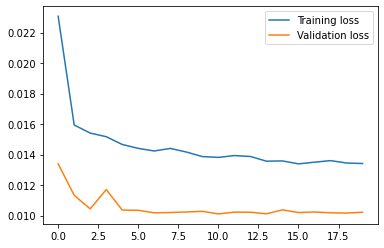



Model performance on training data : 
RMSE : 0.0695676918970894.
MAE : 0.003997092239751554.
MAPE : 27.85838449279045.
How model predict training data : 


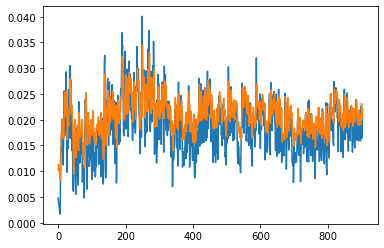

Model performance on verification data : 
RMSE : 0.07358213299772341.
MAE : 0.004580608068521207.
MAPE : 41.06240565050827.
How model predict verification data : 


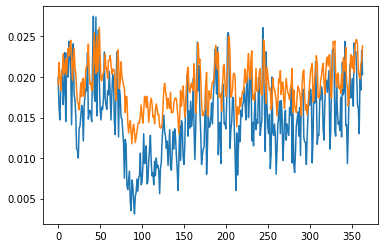





Modelling for : o3.
trainX shape == (5131, 2, 10).
trainY shape == (5131, 1).
testX shape == (904, 2, 10).
testY shape == (904, 1).
verifyX shape == (364, 2, 10).
verifyY shape == (364, 1).


Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_15 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_57 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0145 - val_loss: 0.0118
Epoch 2/20
513/513 [==============================] - 0s 642us/step - loss: 0.0118 - 

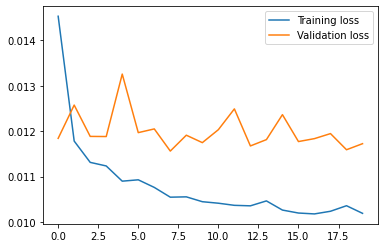



Model performance on training data : 
RMSE : 0.06968489222757522.
MAE : 0.0038726626588542644.
MAPE : 35.52522541245716.
How model predict training data : 


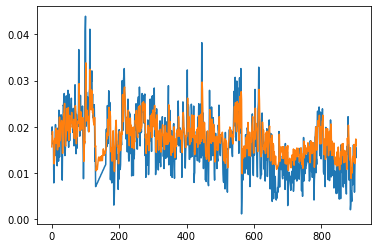

Model performance on verification data : 
RMSE : 0.06629779440149842.
MAE : 0.00347108732120922.
MAPE : 28.141991679056915.
How model predict verification data : 


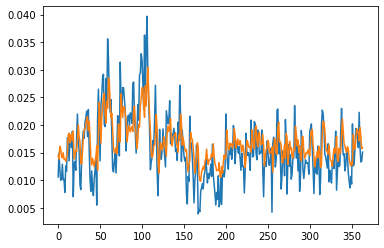





Modelling for : co.
trainX shape == (5131, 2, 10).
trainY shape == (5131, 1).
testX shape == (904, 2, 10).
testY shape == (904, 1).
verifyX shape == (364, 2, 10).
verifyY shape == (364, 1).


Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_16 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_58 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0067 - val_loss: 0.0028
Epoch 2/20
513/513 [==============================] - 0s 648us/step - loss: 0.0041 - 

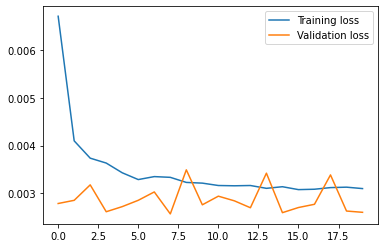



Model performance on training data : 
RMSE : 0.4507073484589327.
MAE : 0.1632566254956005.
MAPE : 24.504884214301047.
How model predict training data : 


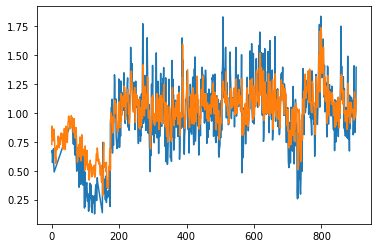

Model performance on verification data : 
RMSE : 0.4349948529484365.
MAE : 0.15665825046418788.
MAPE : 23.092151933123876.
How model predict verification data : 


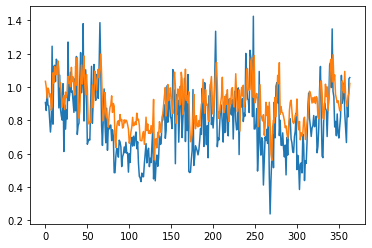





Modelling for : pm10.
trainX shape == (5131, 2, 10).
trainY shape == (5131, 1).
testX shape == (904, 2, 10).
testY shape == (904, 1).
verifyX shape == (364, 2, 10).
verifyY shape == (364, 1).


Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_17 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_59 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 2/20
513/513 [==============================] - 0s 657us/step - loss: 0.0019 

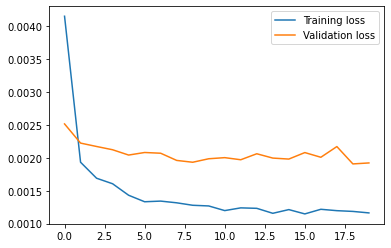



Model performance on training data : 
RMSE : 4.338317008316647.
MAE : 15.321943663808097.
MAPE : 45.475541840580135.
How model predict training data : 


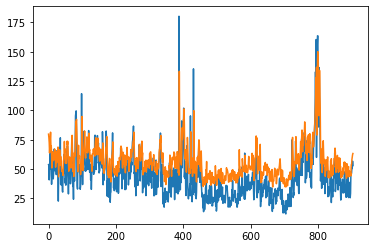

Model performance on verification data : 
RMSE : 4.177266697372505.
MAE : 15.610992285994646.
MAPE : 54.5141184100094.
How model predict verification data : 


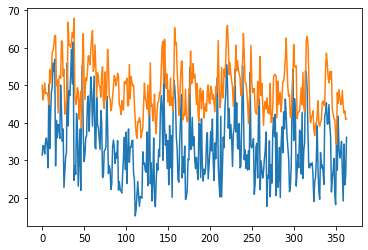

In [35]:
for i in range(4,len(klangapi.columns)):
    print('Modelling for : {}.'.format(klangapi.columns[i]))
    modelling(train,test, 2, i)
    print('\n')
    print('\n')

Modelling for : no.
trainX shape == (5130, 3, 10).
trainY shape == (5130, 1).
testX shape == (903, 3, 10).
testY shape == (903, 1).
verifyX shape == (363, 3, 10).
verifyY shape == (363, 1).


Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_30 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_72 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0202 - val_loss: 0.0068
Epoch 2/20
513/513 [==============================] - 0s 683us/step - loss: 0.0141 - val_

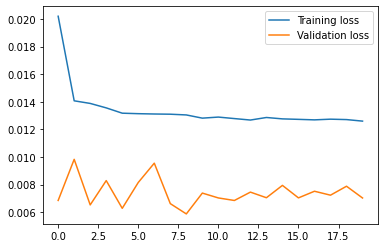



Model performance on training data : 
RMSE : 0.1886570751785513.
MAE : 0.031416054880057984.
MAPE : 189.62337088111505.
How model predict training data : 


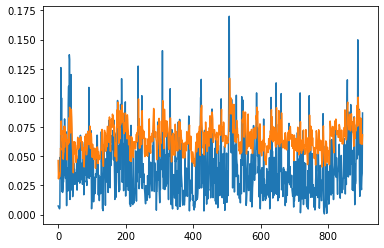

Model performance on verification data : 
RMSE : 0.19688723935838512.
MAE : 0.035743957020116575.
MAPE : 235.35078305411895.
How model predict verification data : 


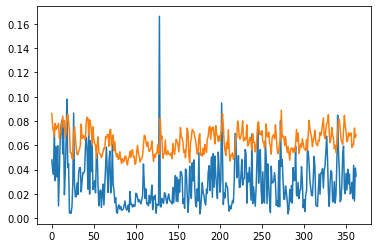





Modelling for : so2.
trainX shape == (5130, 3, 10).
trainY shape == (5130, 1).
testX shape == (903, 3, 10).
testY shape == (903, 1).
verifyX shape == (363, 3, 10).
verifyY shape == (363, 1).


Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_31 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_73 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0181 - val_loss: 0.0088
Epoch 2/20
513/513 [==============================] - 0s 688us/step - loss: 0.0132 -

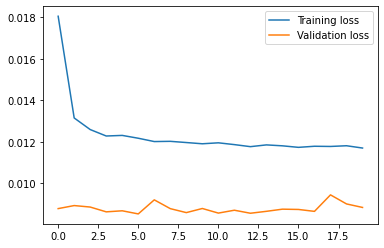



Model performance on training data : 
RMSE : 0.0940762450199062.
MAE : 0.007713121814364083.
MAPE : 298.19619268372367.
How model predict training data : 


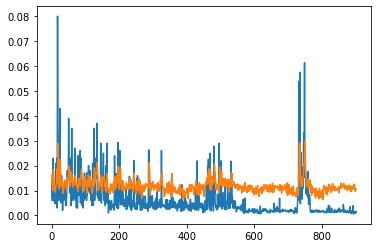

Model performance on verification data : 
RMSE : 0.09262202351110384.
MAE : 0.008074117679514258.
MAPE : 380.77230873598137.
How model predict verification data : 


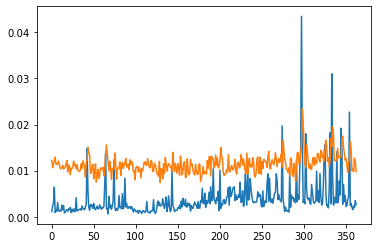





Modelling for : no2.
trainX shape == (5130, 3, 10).
trainY shape == (5130, 1).
testX shape == (903, 3, 10).
testY shape == (903, 1).
verifyX shape == (363, 3, 10).
verifyY shape == (363, 1).


Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_32 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_74 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0066
Epoch 2/20
513/513 [==============================] - 0s 683us/step - loss: 0.0085 -

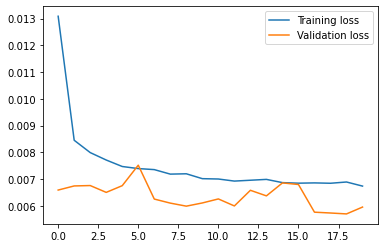



Model performance on training data : 
RMSE : 0.09658608224495789.
MAE : 0.007512095657766592.
MAPE : 28.965728853543066.
How model predict training data : 


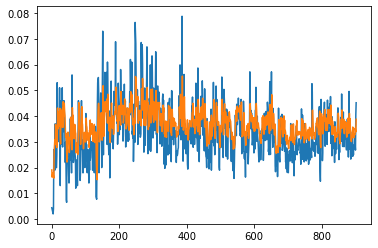

Model performance on verification data : 
RMSE : 0.09629945269333409.
MAE : 0.007627993286452345.
MAPE : 35.65729112148724.
How model predict verification data : 


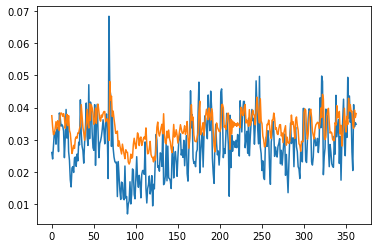





Modelling for : o3.
trainX shape == (5130, 3, 10).
trainY shape == (5130, 1).
testX shape == (903, 3, 10).
testY shape == (903, 1).
verifyX shape == (363, 3, 10).
verifyY shape == (363, 1).


Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_33 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_75 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0226 - val_loss: 0.0163
Epoch 2/20
513/513 [==============================] - 0s 682us/step - loss: 0.0187 - 

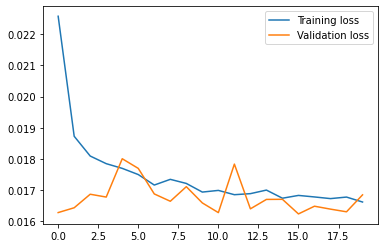



Model performance on training data : 
RMSE : 0.12071844142913223.
MAE : 0.011813785817971658.
MAPE : 45.746122451447974.
How model predict training data : 


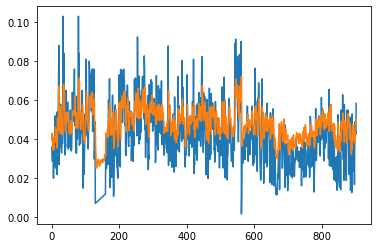

Model performance on verification data : 
RMSE : 0.11478858861896062.
MAE : 0.010831018338748576.
MAPE : 35.33877953278163.
How model predict verification data : 


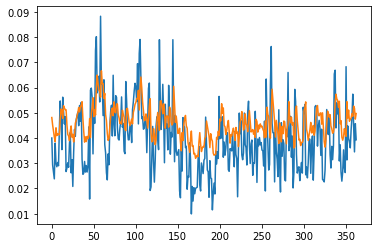





Modelling for : co.
trainX shape == (5130, 3, 10).
trainY shape == (5130, 1).
testX shape == (903, 3, 10).
testY shape == (903, 1).
verifyX shape == (363, 3, 10).
verifyY shape == (363, 1).


Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_34 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_76 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0103 - val_loss: 0.0046
Epoch 2/20
513/513 [==============================] - 0s 685us/step - loss: 0.0054 - 

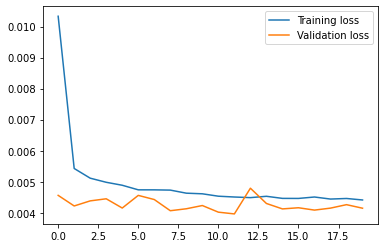



Model performance on training data : 
RMSE : 0.8919462545132829.
MAE : 0.6535464253851213.
MAPE : 57.542982501502415.
How model predict training data : 


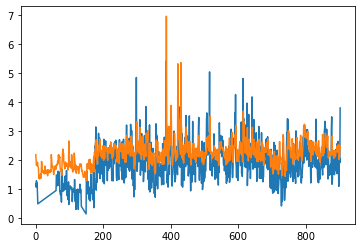

Model performance on verification data : 
RMSE : 0.8530757281691919.
MAE : 0.6405605685704339.
MAPE : 56.87420496346229.
How model predict verification data : 


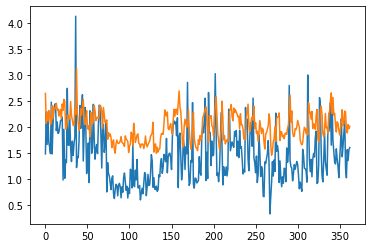





Modelling for : pm10.
trainX shape == (5130, 3, 10).
trainY shape == (5130, 1).
testX shape == (903, 3, 10).
testY shape == (903, 1).
verifyX shape == (363, 3, 10).
verifyY shape == (363, 1).


Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_35 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_77 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 2ms/step - loss: 0.0070 - val_loss: 0.0035
Epoch 2/20
513/513 [==============================] - 0s 719us/step - loss: 0.0023 

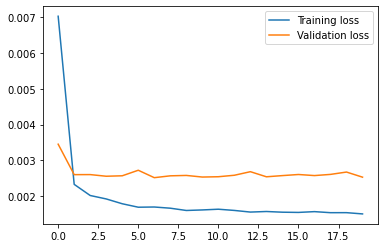



Model performance on training data : 
RMSE : 9.539978216933848.
MAE : 35.569322882458586.
MAPE : 43.99672081913042.
How model predict training data : 


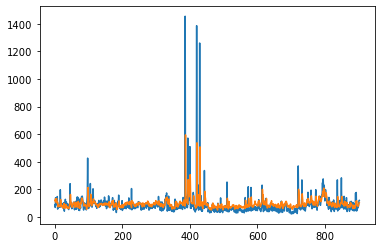

Model performance on verification data : 
RMSE : 5.616407005046052.
MAE : 23.48789256383302.
MAPE : 40.83942095741233.
How model predict verification data : 


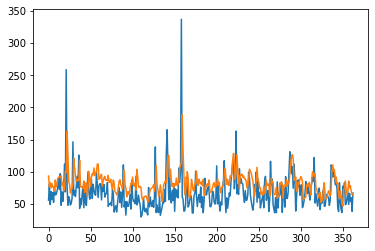

In [50]:
for i in range(4,len(klangapi.columns)):
    print('Modelling for : {}.'.format(klangapi.columns[i]))
    modelling(train,test, 3, i)
    print('\n')
    print('\n')

Modelling for : no.
trainX shape == (5129, 4, 10).
trainY shape == (5129, 1).
testX shape == (902, 4, 10).
testY shape == (902, 1).
verifyX shape == (362, 4, 10).
verifyY shape == (362, 1).


Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_24 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_66 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 2ms/step - loss: 0.0168 - val_loss: 0.0051
Epoch 2/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0124 - val_lo

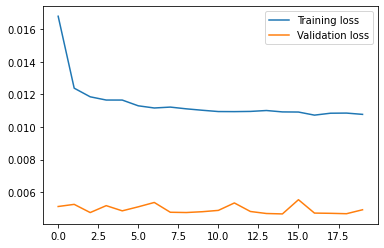



Model performance on training data : 
RMSE : 0.08626082288797167.
MAE : 0.006318030903566868.
MAPE : 129.4706170775026.
How model predict training data : 


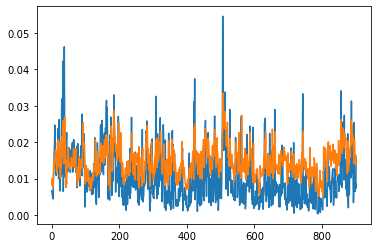

Model performance on verification data : 
RMSE : 0.08741130773069793.
MAE : 0.006884434028043932.
MAPE : 154.61710820850473.
How model predict verification data : 


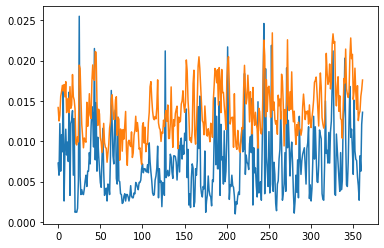





Modelling for : so2.
trainX shape == (5129, 4, 10).
trainY shape == (5129, 1).
testX shape == (902, 4, 10).
testY shape == (902, 1).
verifyX shape == (362, 4, 10).
verifyY shape == (362, 1).


Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_25 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_67 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 2ms/step - loss: 0.0111 - val_loss: 0.0035
Epoch 2/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0069 - v

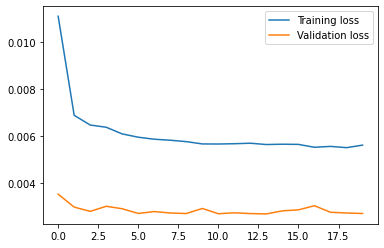



Model performance on training data : 
RMSE : 0.04184484089455354.
MAE : 0.0015976116630170255.
MAPE : 130.53071284576993.
How model predict training data : 


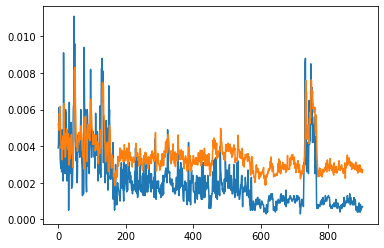

Model performance on verification data : 
RMSE : 0.04352590704586785.
MAE : 0.0018176061461592163.
MAPE : 177.80798917166288.
How model predict verification data : 


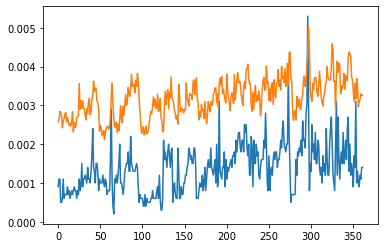





Modelling for : no2.
trainX shape == (5129, 4, 10).
trainY shape == (5129, 1).
testX shape == (902, 4, 10).
testY shape == (902, 1).
verifyX shape == (362, 4, 10).
verifyY shape == (362, 1).


Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_26 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_68 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 2ms/step - loss: 0.0235 - val_loss: 0.0129
Epoch 2/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0163 - v

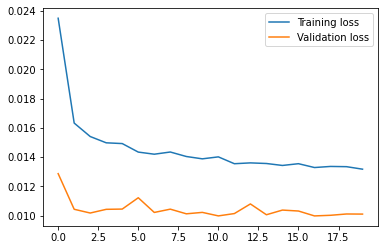



Model performance on training data : 
RMSE : 0.0695470606231808.
MAE : 0.004018804110712196.
MAPE : 27.960226523093272.
How model predict training data : 


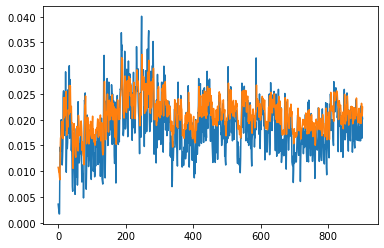

Model performance on verification data : 
RMSE : 0.07370157963788602.
MAE : 0.004601549817815177.
MAPE : 41.36431165166523.
How model predict verification data : 


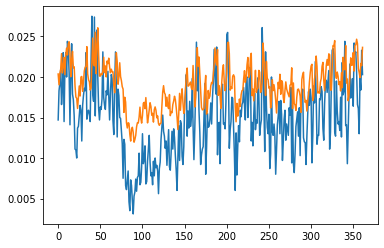





Modelling for : o3.
trainX shape == (5129, 4, 10).
trainY shape == (5129, 1).
testX shape == (902, 4, 10).
testY shape == (902, 1).
verifyX shape == (362, 4, 10).
verifyY shape == (362, 1).


Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_27 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_69 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 2ms/step - loss: 0.0159 - val_loss: 0.0115
Epoch 2/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0118 - va

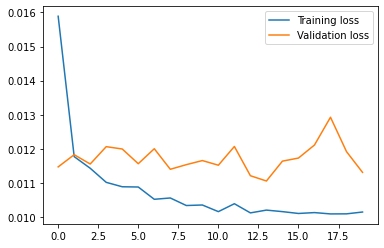



Model performance on training data : 
RMSE : 0.06713257060503733.
MAE : 0.0034843099184565566.
MAPE : 28.7608953135215.
How model predict training data : 


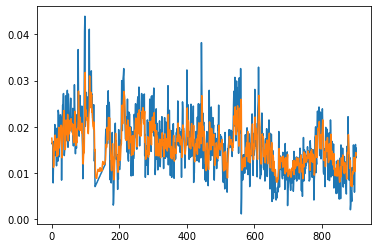

Model performance on verification data : 
RMSE : 0.06508091320915144.
MAE : 0.0031375385615727684.
MAPE : 22.83002253580933.
How model predict verification data : 


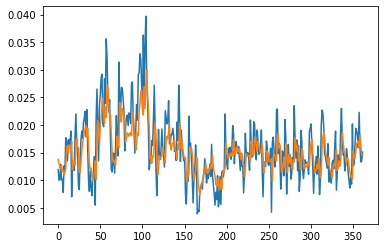





Modelling for : co.
trainX shape == (5129, 4, 10).
trainY shape == (5129, 1).
testX shape == (902, 4, 10).
testY shape == (902, 1).
verifyX shape == (362, 4, 10).
verifyY shape == (362, 1).


Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_28 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_70 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 2ms/step - loss: 0.0078 - val_loss: 0.0032
Epoch 2/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0041 - va

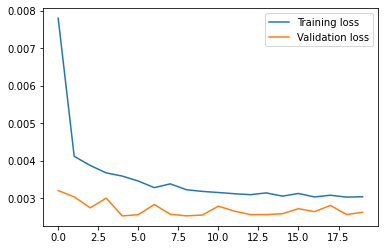



Model performance on training data : 
RMSE : 0.4546794349701573.
MAE : 0.16818959353414184.
MAPE : 25.388709474398535.
How model predict training data : 


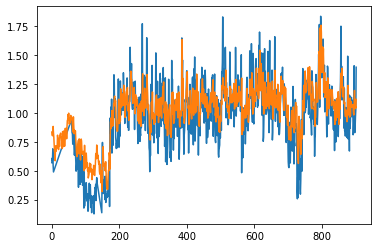

Model performance on verification data : 
RMSE : 0.4491070824678125.
MAE : 0.169561608110607.
MAPE : 25.2461681316136.
How model predict verification data : 


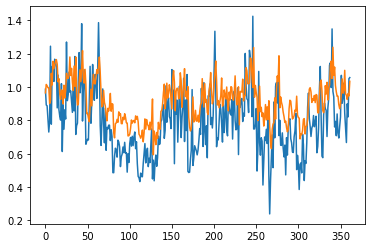





Modelling for : pm10.
trainX shape == (5129, 4, 10).
trainY shape == (5129, 1).
testX shape == (902, 4, 10).
testY shape == (902, 1).
verifyX shape == (362, 4, 10).
verifyY shape == (362, 1).


Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_29 (GRU)                 (None, 32)                4224      
_________________________________________________________________
dropout_71 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 33        
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
513/513 [==============================] - 1s 2ms/step - loss: 0.0057 - val_loss: 0.0023
Epoch 2/20
513/513 [==============================] - 1s 1ms/step - loss: 0.0021 - 

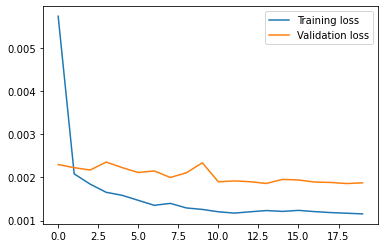



Model performance on training data : 
RMSE : 4.111288918428761.
MAE : 13.253958658131264.
MAPE : 38.831825498321685.
How model predict training data : 


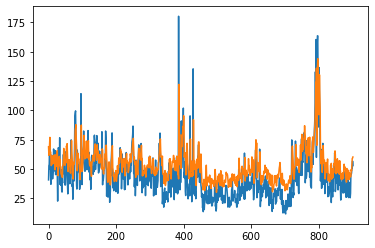

Model performance on verification data : 
RMSE : 3.8555896768680498.
MAE : 12.92248925975989.
MAPE : 45.638481382078155.
How model predict verification data : 


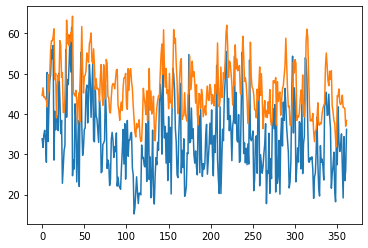

In [37]:
for i in range(4,len(klangapi.columns)):
    print('Modelling for : {}.'.format(klangapi.columns[i]))
    modelling(train,test, 4, i)
    print('\n')
    print('\n')